# Classifying Urban sounds using Deep Learning

## 2 Data Preprocessing and Data Splitting

### Audio properties that will require normalising 

Following on from the previous notebook, we identifed the following audio properties that need preprocessing to ensure consistency across the whole dataset:  

- Audio Channels 
- Sample rate 
- Bit-depth

We will continue to use Librosa which will be useful for the pre-processing and feature extraction. 

### Preprocessing stage 

For much of the preprocessing we will be able to use [Librosa's load() function.](https://librosa.github.io/librosa/generated/librosa.core.load.html) 

We will compare the outputs from Librosa against the default outputs of [scipy's wavfile library](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html) using a chosen file from the dataset. 

#### Sample rate conversion 

By default, Librosa’s load function converts the sampling rate to 22.05 KHz which we can use as our comparison level. 

In [1]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

filename = './improved_dataset/0007c6f1-5441-40e6-9aaf-a761d8f2da3b.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 48000
Librosa sample rate: 22050


#### Bit-depth 

Librosa’s load function will also normalise the data so it's values range between -1 and 1. This removes the complication of the dataset having a wide range of bit-depths. 

In [2]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -114073912 to 108576344
Librosa audio file min~max range: -0.05301139 to 0.05062752


#### Merge audio channels 

Librosa will also convert the signal to mono, meaning the number of channels will always be 1. 

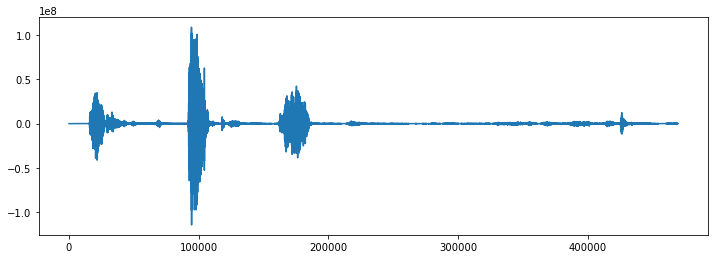

In [3]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

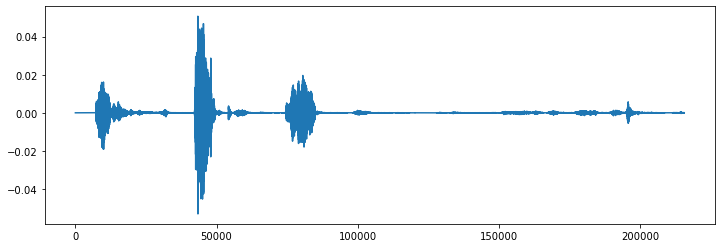

In [4]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

In [5]:
#for pos
filename_pos = './improved_dataset/00357712-dd5a-4c0a-90a4-39f1f4b9d5fd.wav' 

librosa_audio_pos, librosa_sample_rate_pos = librosa.load(filename_pos) 
scipy_sample_rate_pos, scipy_audio_pos = wav.read(filename_pos) 

print('Original sample rate:', scipy_sample_rate_pos) 
print('Librosa sample rate:', librosa_sample_rate_pos)

Original sample rate: 48000
Librosa sample rate: 22050


In [6]:
print('Original audio file min~max range:', np.min(scipy_audio_pos), 'to', np.max(scipy_audio_pos))
print('Librosa audio file min~max range:', np.min(librosa_audio_pos), 'to', np.max(librosa_audio_pos))

Original audio file min~max range: -72565032 to 37972320
Librosa audio file min~max range: -0.010910107 to 0.00449361


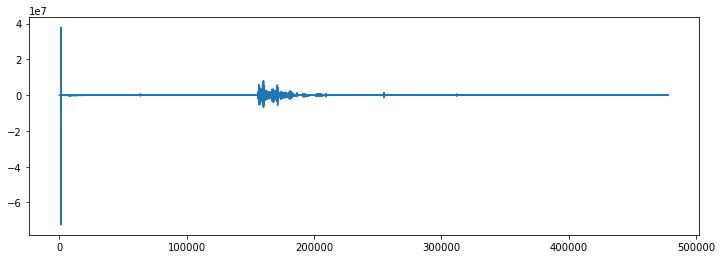

In [7]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio_pos)

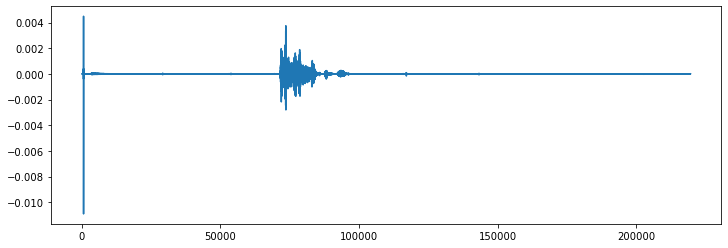

In [8]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_pos)

#### Other audio properties to consider

At this stage it is not yet clear whether other factors may also need to be taken into account, such as sample duration length and volume levels. 

We will proceed as is for the meantime and come back to address these later if it's perceived to be effecting the validity of our target metrics. 

### Extract Features 

As outlined in the proposal, we will extract [Mel-Frequency Cepstral Coefficients (MFCC)](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) from the the audio samples. 

The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification. 

#### Extracting a MFCC

For this we will use [Librosa's mfcc() function](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html) which generates an MFCC from time series audio data. 

In [9]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 422)


This shows librosa calculated a series of 40 MFCCs over 791 frames. 

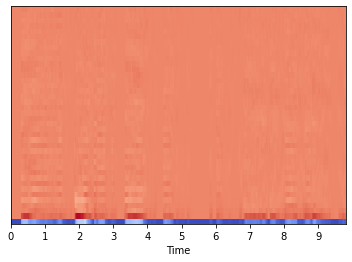

In [10]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

In [11]:
# plt.imshow(mfccs)

In [12]:
#for pos
mfccs_pos = librosa.feature.mfcc(y=librosa_audio_pos, sr=librosa_sample_rate_pos, n_mfcc=40)
print(mfccs.shape)

(40, 422)


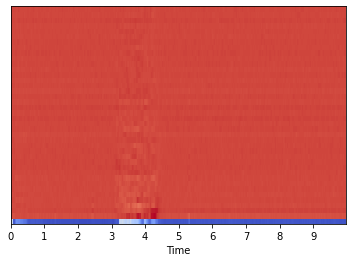

In [13]:
import librosa.display
librosa.display.specshow(mfccs_pos, sr=librosa_sample_rate_pos, x_axis='time')

In [14]:
# plt.imshow(mfccs_pos)

#### Extracting MFCC's for every file 

We will now extract an MFCC for each audio file in the dataset and store it in a Panda Dataframe along with it's classification label. 

In [21]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print(str(e))
        #print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccsscaled

In [22]:
# Load various imports 
import pandas as pd
import os
import librosa

In [ ]:



# Set the path to the full UrbanSound dataset 

metadata = pd.read_csv('./metadata_compiled.csv')
print("metadata")

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath('/improved_dataset'),str(row["uuid"]+".wav"))
#     print("forloop")
#     if row["corona_test"]=="negative":
#         file_name = os.path.join(os.path.abspath('clinical/converted_seg/cneg/'),str(row["cough_filename"]))
#     else:
#         file_name = os.path.join(os.path.abspath('clinical/converted_seg/cpos/'),str(row["cough_filename"]))
    
    class_label = row["status"]
    data = extract_features(file_name)
#     print("file done")
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files') 

metadata
[Errno 2] No such file or directory: 'C:\\improved_dataset\\00039425-7f3a-42aa-ac13-834aaa2b6b92.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\0007c6f1-5441-40e6-9aaf-a761d8f2da3b.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\0009eb28-d8be-4dc1-92bb-907e53bc5c7a.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\001d8e33-a4af-4edb-98ba-b03f891d9a6c.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\001e2f19-d81c-4029-b33c-d2db56b23a4a.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\0028b68c-aca4-4f4f-bb1d-cb4ed5bbd952.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\00291cce-36a0-4a29-9e2d-c1d96ca17242.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\0029d048-898a-4c70-89c7-0815cdcf7391.wav'
[Errno 2] No such file or directory: 'C:\\improved_dataset\\002d28bc-7806

In [ ]:
featu

### Convert the data and labels

We will use `sklearn.preprocessing.LabelEncoder` to encode the categorical text data into model-understandable numerical data. 

In [1]:
featuresdf.head()

NameError: name 'featuresdf' is not defined

In [19]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 


In [20]:
yy.head()

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

### Split the dataset

Here we will use `sklearn.model_selection.train_test_split` to split the dataset into training and testing sets. The testing set size will be 20% and we will set a random state. 


In [21]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.4, random_state = 42)

### Store the preprocessed data 

In [22]:
### store the preprocessed data for use in the next notebook

%store x_train 
%store x_test 
%store y_train 
%store y_test 
%store yy 
%store le

Stored 'x_train' (ndarray)
Stored 'x_test' (ndarray)
Stored 'y_train' (ndarray)
Stored 'y_test' (ndarray)
Stored 'yy' (ndarray)
Stored 'le' (LabelEncoder)


### *In the next notebook we will develop our model*